## **Tempo Detection for Accompaniment Recordings**
This notebook is designed to test various tempo detection methods on accompaniment recordings and in real-time.

### Approaches For Tempo Detection
1. Traditional approach of onset detection (STFT + spectral flux) and then compute tempo from the detected onsets. (***Problem:** seems to be quite sensitive to the parameters used*). Maybe try image processing on the tempogram to get tempo? Experiment with downsampling.
2. Window + lowpass filter each frame of the signal to 20-45 Hz (corresponding to common tempo BPMs) and look at the max frequency component. Maybe do this on the onset envelope if it works better. This is the simplest approach but may not be the most effective. 
3. Similar to decoding an on-off keyed message (i.e. 1 if start of a beat, 0 if not start of a beat). This just involves computing the power of the frequency spectrum of each frame ("bit") and comparing with a threshold. This approach is likely combined with other approaches. 
4. Try wavelet transform instead of stft for onset detection (find power of frequency spectrum of each frame and compute spectral flux). What if each basis function was a wavelet + sin wave?

### Additional Ideas
1. Maybe have the user clap a few times before to establiish a tempo to "calibrate" the alogrithm. Not sure how useful this is in detecting the tempo of the recording, but it helps with syncing at the start.
2. Support different modes:
    - Solo mode: recording always follows the musician. For general practice.
    - Orchestral mode: musicians can set accompanist to match a conductor (timings are determined from a video of the conductor). For orchestral musician practice.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from scipy.signal import butter, sosfilt
import os
from math import ceil

In [53]:
#  choose audio file
name = 'metronome_108'
filename = f'{name}.mp3'

In [54]:
# load audio file
audio_path = f'../audio_in/{filename}'
if not os.path.exists(audio_path):
	raise FileNotFoundError(f"Audio file not found: {audio_path}")

signal, sr = librosa.load(audio_path, sr=None)  
signal -= np.mean(signal) # remove DC offset
t = np.arange(len(signal))/sr
print(f'Sample rate: {sr}')
print(f'Signal length: {len(signal)}')
print(f'Signal duration: {len(signal)/sr:.3f} s')

Sample rate: 44100
Signal length: 373696
Signal duration: 8.474 s


Text(0, 0.5, 'Amplitude')

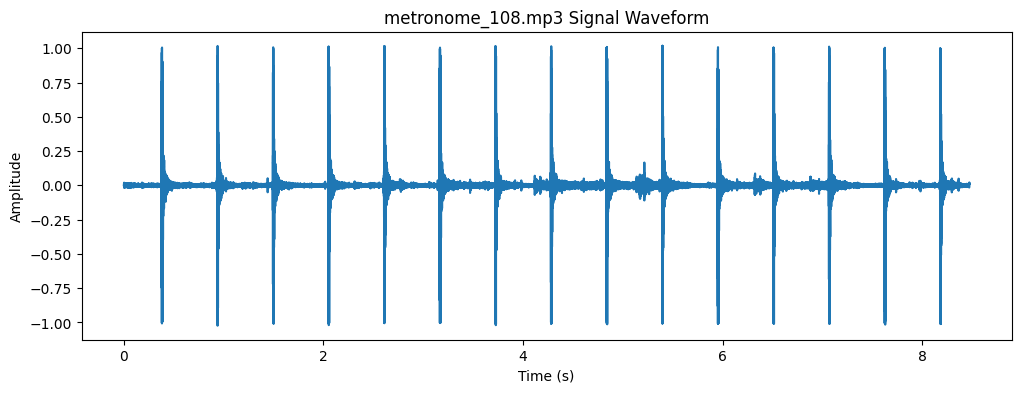

In [55]:
# plot signal waveform
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.title(f'{filename} Signal Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

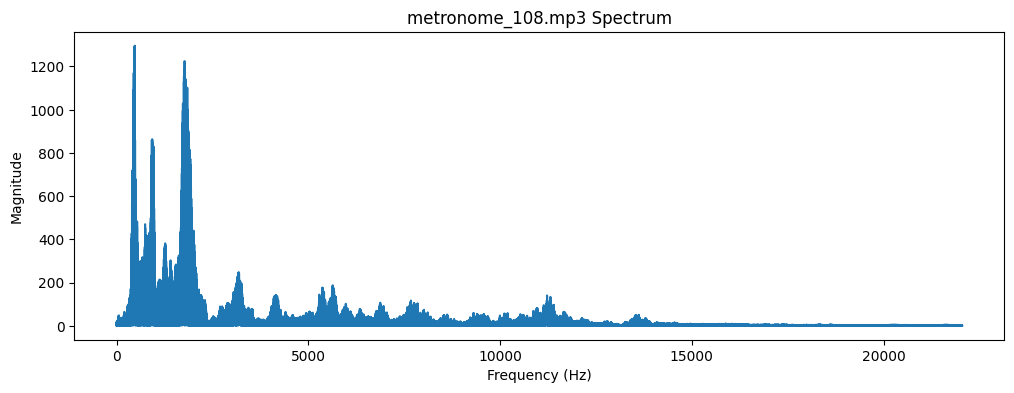

In [56]:
# plot signal spectrum
def plot_spectrum(signal, sr, filename, filtered=False):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, d=1/sr)
    fft_vals = np.fft.rfft(signal)
    magnitude = np.abs(fft_vals)

    plt.figure(figsize=(12, 4))
    plt.plot(freqs, magnitude)
    if filtered: plt.title(f'{filename} Filtered Spectrum')
    else: plt.title(f'{filename} Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

plot_spectrum(signal, sr, filename)

### 1. Traditional Approach

In [57]:
# define parameters
hop_length = 256 # samples per frame 
time_res = hop_length/sr # time per frame, temporal resolution
win_dur = 4 # window length in seconds
win_length = int((win_dur*sr)/hop_length) # window length in frames
print(f'Time resolution: {time_res:.3f} s')

Time resolution: 0.006 s


In [58]:
# bandpass filter
def bandpass_filter(signal, sr, lowcut=60, highcut=4000, order=5):
    sos = butter(order, [lowcut, highcut], btype='bandpass', fs=sr, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

# lowpass filter
def lowpass_filter(signal, sr, cutoff=4000, order=5):
    sos = butter(order, cutoff, btype='lowpass', fs=sr, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

# highpass filter
def highpass_filter(signal, sr, cutoff=60, order=5):
    sos = butter(order, cutoff, btype='highpass', fs=sr, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

In [ ]:
# bandpass filter original signal
signal = bandpass_filter(signal, sr, lowcut=20, highcut=4000)

# sr = 10000
# signal = librosa.resample(signal, orig_sr=sr, target_sr=sr)
# t = np.arange(len(signal))/sr

# play signal
sf.write(f'../audio_out/{name}_filtered.wav', signal, sr)

Text(0, 0.5, 'Amplitude')

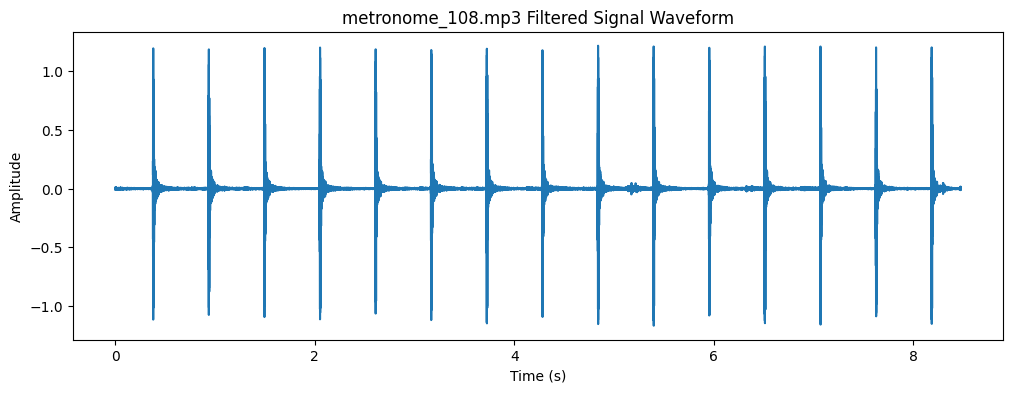

In [60]:
# plot filtered signal
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.title(f'{filename} Filtered Signal Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

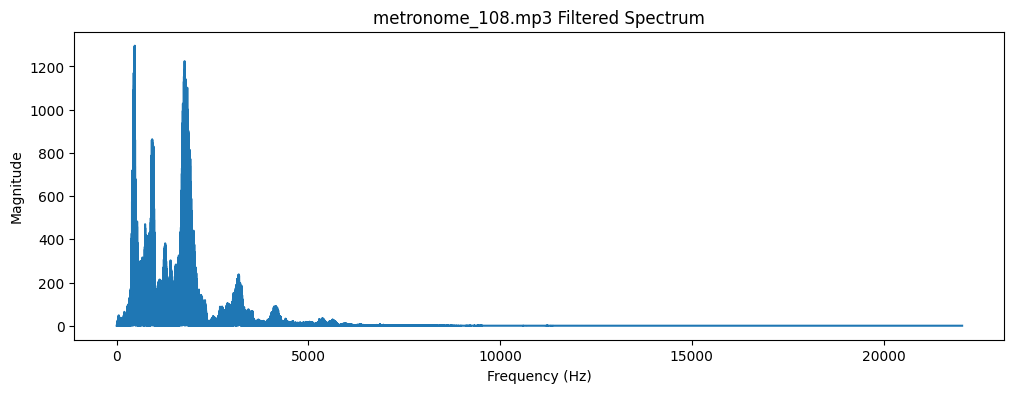

In [61]:
# plot spectrum of filtered signal
plot_spectrum(signal, sr, filename, filtered=True)

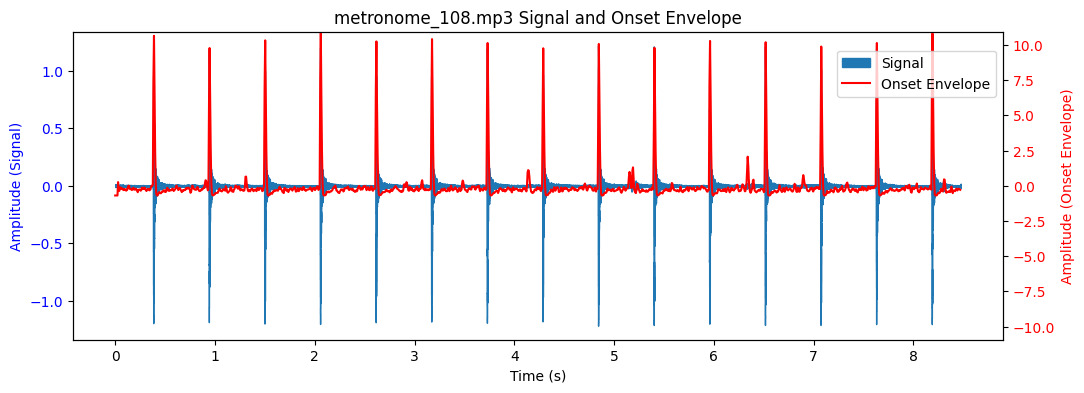

In [62]:
# find onset envelope
onset_env = librosa.onset.onset_strength(y=signal, sr=sr, hop_length=hop_length)
onset_env -= np.mean(onset_env)
if np.all(onset_env == 0): raise ValueError('Onset envelope is all zeros. Try a different audio file.')

# plot onset envelope overlaid with original signal
fig, ax1 = plt.subplots(figsize=(12, 4))

librosa.display.waveshow(signal, sr=sr, ax=ax1, label='Signal')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (Signal)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

max_onset = np.max(np.abs(onset_env))
ax2 = ax1.twinx()
ax2.plot(np.arange(len(onset_env))*time_res, onset_env, label='Onset Envelope', color='r')
ax2.set_ylabel('Amplitude (Onset Envelope)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(-max_onset, max_onset)

plt.title(f'{filename} Signal and Onset Envelope')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))
plt.show()

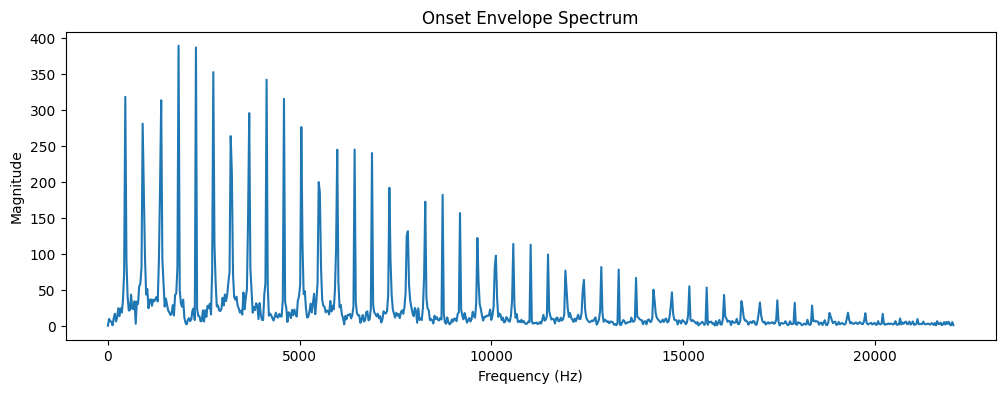

In [63]:
# plot onset envelope spectrum
plot_spectrum(onset_env, sr, 'Onset Envelope')

In [64]:
# filter onset envelope
onset_env = lowpass_filter(onset_env, sr, cutoff=10000)

# keep values avove threshold
threshold = 0.05 * np.max(onset_env)
onset_env[onset_env < threshold] = 0
onset_env -= np.mean(onset_env)

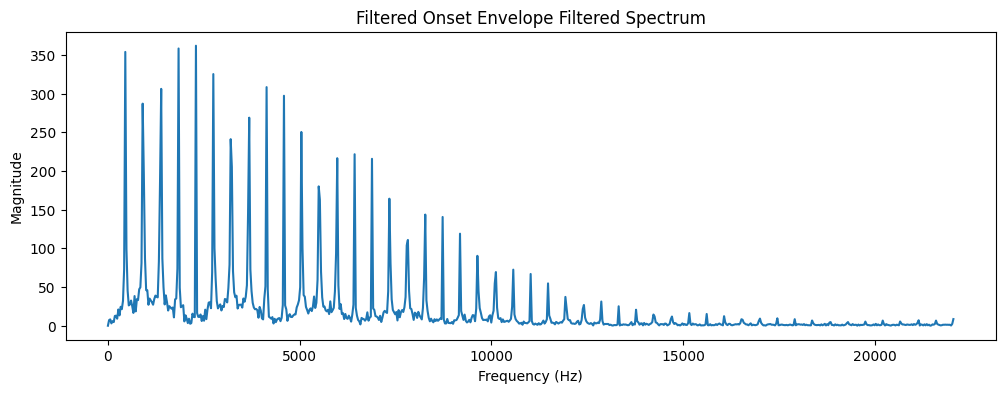

In [65]:
# plot filtered onset envelope spectrum
plot_spectrum(onset_env, sr, 'Filtered Onset Envelope', filtered=True)

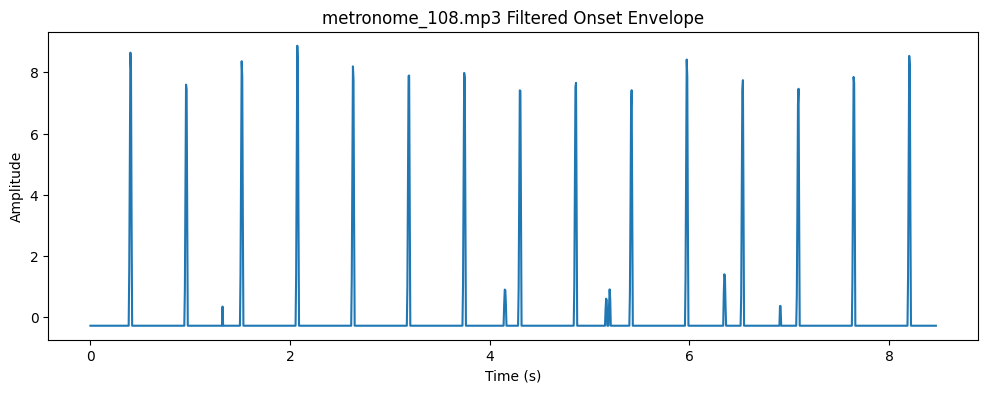

In [66]:
# plot filtered onset envelope
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(onset_env))*time_res, onset_env)
plt.title(f'{filename} Filtered Onset Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
_ = plt.xticks(np.arange(0, len(onset_env)*time_res, 2))

In [67]:
# compute tempogram, skipping first bin
tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length, win_length=win_length)[1:,:]
tempo_bins = librosa.tempo_frequencies(tempogram.shape[0], sr=sr, hop_length=hop_length)
tempo_bins = np.sort(tempo_bins)

# for limiting tempo of tempogram
fmin = max(35, tempo_bins[0])
fmax = min(200, tempo_bins[-1])

print(f'Max tempo: {fmax:.2f} BPM')
print(f'Min tempo: {fmin:.2f} BPM')
print(f'Number of tempo bins: {len(tempo_bins)}')

Max tempo: 200.00 BPM
Min tempo: 35.00 BPM
Number of tempo bins: 688


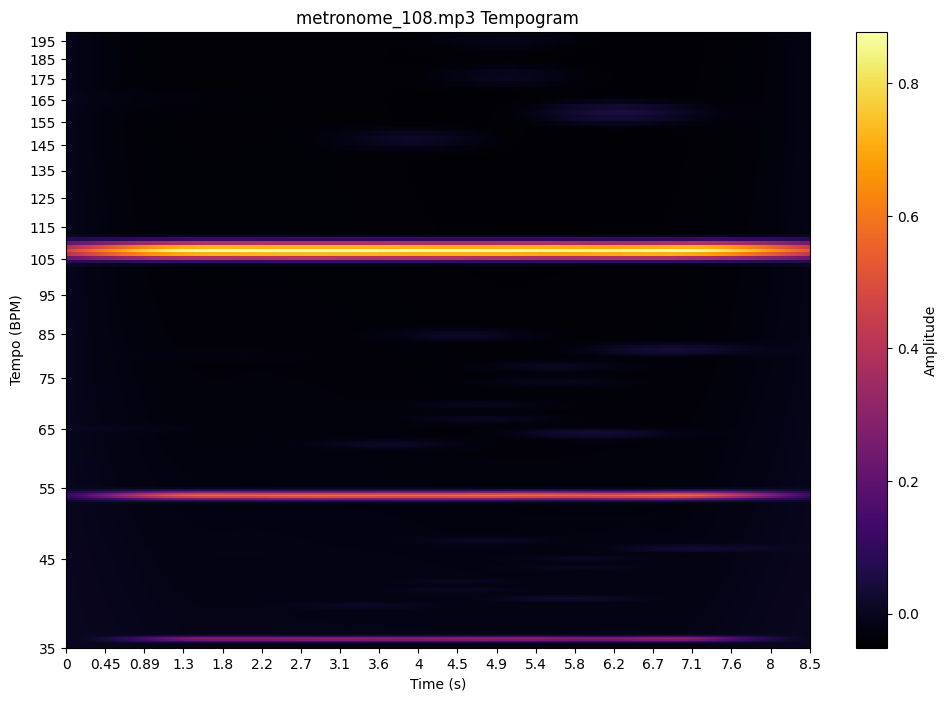

In [68]:
# plot tempogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length, x_axis='time', 
                         y_axis='tempo', cmap='inferno')
plt.ylim(fmin, fmax) 
plt.colorbar(label='Amplitude')
plt.title(f'{filename} Tempogram')
plt.xlabel('Time (s)')
plt.ylabel('Tempo (BPM)')

yticks = np.arange(ceil(fmin), ceil(fmax), 10)
_ = plt.yticks(yticks)
_ = plt.xticks(np.linspace(0, tempogram.shape[1] * time_res, 20))

Using tempo bins from index 392 to index 635
Using tempo bins from 35.04 to 198.77 BPM
Estimated tempos: [38.13999077490775, 38.13999077490775, 37.99977022058823, 37.99977022058823, 37.86057692307692, 37.86057692307692, 37.722399635036496, 37.722399635036496, 37.722399635036496, 37.58522727272727, 37.58522727272727, 37.58522727272727, 76.5625, 75.44479927007299, 74.35926258992805, 45.13509825327511, 44.74431818181818, 44.55145474137931, 44.17067307692308, 43.982712765957444, 43.611550632911396, 43.42830882352941, 43.24660041841004, 43.06640625, 42.88770746887967, 42.71048553719008, 42.53472222222222, 42.36039959016394, 42.36039959016394, 42.1875, 42.1875, 42.016006097560975, 42.016006097560975, 42.016006097560975, 41.845900809716596, 41.845900809716596, 41.845900809716596, 41.845900809716596, 41.845900809716596, 65.83399681528662, 35.03707627118644, 35.03707627118644, 35.03707627118644, 35.03707627118644, 35.03707627118644, 35.03707627118644, 35.03707627118644, 35.03707627118644, 35.03

(35.0, 200.0)

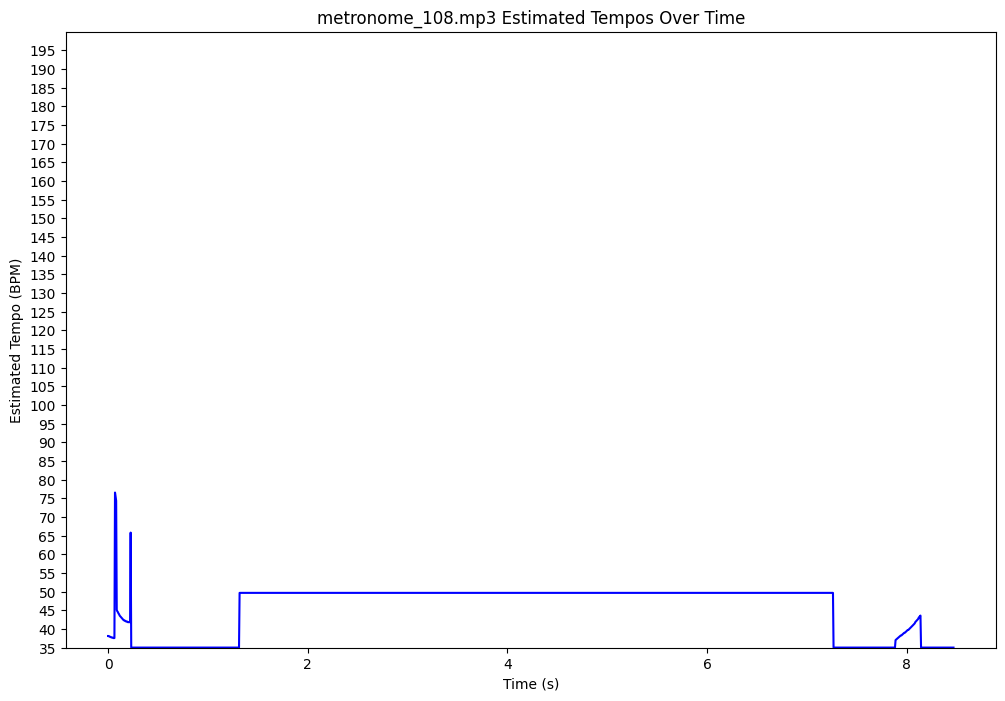

In [69]:
# extract tempos from tempogram
peaks_per_frame = []
# find indices of fmin and fmax in tempo_bins
fmin_idx = np.where(tempo_bins>=fmin)[0][0]
fmax_idx = np.where(tempo_bins<=fmax)[0][-1]
print(f'Using tempo bins from index {fmin_idx} to index {fmax_idx}')
print(f'Using tempo bins from {tempo_bins[fmin_idx]:.2f} to {tempo_bins[fmax_idx]:.2f} BPM')

peaks_per_frame = []
for i in range(tempogram.shape[1]):
    search_slice = np.abs(tempogram[fmin_idx:fmax_idx, i])
    if len(search_slice) > 0: peaks_per_frame.append(fmin_idx + np.argmax(search_slice))
    else: peaks_per_frame.append(-1)

estim_tempos = [float(tempo_bins[peaks]) if peaks >= 0 else -1 for peaks in peaks_per_frame]
tempo_t = np.arange(len(estim_tempos))*time_res
print(f'Estimated tempos: {estim_tempos}')

# plot estimated tempos vs time
plt.figure(figsize=(12, 8))
plt.plot(tempo_t, estim_tempos, color='b')
plt.title(f'{filename} Estimated Tempos Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Estimated Tempo (BPM)')
plt.yticks(np.arange(int(fmin), int(fmax), 5))
plt.ylim(fmin, fmax)

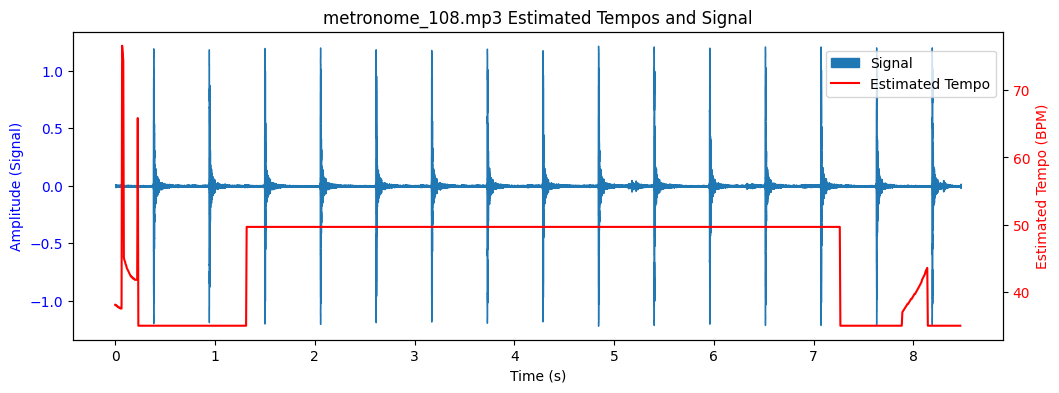

In [70]:
# plot estimated tempos and original signal
fig, ax1 = plt.subplots(figsize=(12, 4))
librosa.display.waveshow(signal, sr=sr, ax=ax1, label='Signal')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (Signal)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(tempo_t, estim_tempos, color='r', label='Estimated Tempo')
ax2.set_ylabel('Estimated Tempo (BPM)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title(f'{filename} Estimated Tempos and Signal')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))

In [71]:
# detect start
def detect_start(signal, sr, hop_length):
    onset_env = librosa.onset.onset_strength(y=signal, sr=sr, hop_length=hop_length)
    start_frame = np.argmax(onset_env)
    start_time = start_frame * hop_length/sr
    return start_time

# zero pad signal to start at signal
def zero_pad_signal(signal, start_time, sr, hop_length):
    start_frame = int(start_time*sr/hop_length)
    padded_signal = np.zeros(start_frame) # zero padding
    padded_signal = np.concatenate((padded_signal, signal))
    return padded_signal

Click track saved to: ../audio_out/click_metronome_108.mp3.wav


Text(0, 0.5, 'Amplitude')

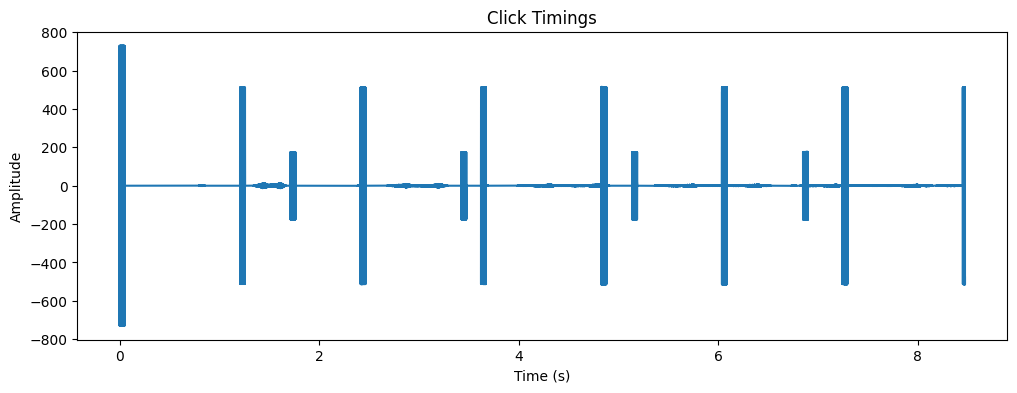

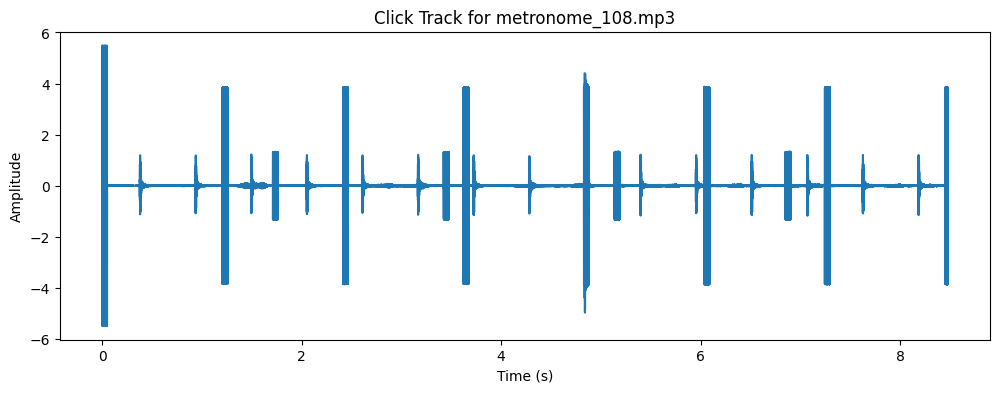

In [72]:
# generate click track to verify estimated tempos
def generate_click_track(tempos, sr, duration, click_freq=1000):
    click_track = np.zeros(int(sr*duration))
    click_length = int(0.05*sr) # 50 ms click in samples
    for tempo in tempos:
        if tempo > 0:
            T = 60/tempo # BPM to seconds
            click_interval = int(T*sr) # interval in samples
            for i in range(0, len(click_track), click_interval):
                if i + click_length <= len(click_track): click_track[i:i + click_length] += 0.5 # add click sound
                else: click_track[i:] += 0.5
    
    sin_wave = np.sin(2*np.pi*click_freq*np.arange(len(click_track))/sr)
    click_track *= sin_wave # modulate click track with sine wave

    # plot click track
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(len(click_track))/sr, click_track)
    plt.title('Click Timings')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    return click_track

click_track = signal + 0.0075*generate_click_track(estim_tempos, sr, len(signal)/sr)

# save click track to file
click_track_path = f'../audio_out/click_{filename}.wav'
sf.write(click_track_path, click_track, sr)
print(f'Click track saved to: {click_track_path}')

# plot click track
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(click_track))/sr, click_track)
plt.title(f'Click Track for {filename}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')